In [6]:
import os

base = "/kaggle/input/blur-detection"
root = "/kaggle/working/doc_quality_dataset"
os.makedirs(root, exist_ok=True)

for cls in ["clean", "blur"]:
    os.makedirs(f"{root}/{cls}", exist_ok=True)

print("✅ Dataset folders created!")


✅ Dataset folders created!


In [9]:
import shutil
import glob

source_base = "/kaggle/input/blur-dataset"

# Clean images
for f in glob.glob(f"{source_base}/sharp/*"):
    shutil.copy(f, f"{root}/clean/")

# Blurred images = motion + defocus
for f in glob.glob(f"{source_base}/motion_blurred/*"):
    shutil.copy(f, f"{root}/blur/")
    
for f in glob.glob(f"{source_base}/defocused_blurred/*"):
    shutil.copy(f, f"{root}/blur/")

print("✅ Images copied successfully!")
print("Clean count:", len(os.listdir(f"{root}/clean")))
print("Blur count:", len(os.listdir(f"{root}/blur")))


✅ Images copied successfully!
Clean count: 350
Blur count: 700


In [14]:
!pip install tensorflow -q
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

IMG_SIZE = (224,224)
BATCH = 32

datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2,
    rotation_range=2,
    zoom_range=0.05,
)

train_gen = datagen.flow_from_directory(
    root, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='categorical', subset='training', shuffle=True
)

val_gen = datagen.flow_from_directory(
    root, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='categorical', subset='validation', shuffle=False
)

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(2, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=6)

model.save("/kaggle/working/blur_classifier.h5")
print("✅ Model saved!")


Found 840 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Epoch 1/6


I0000 00:00:1762452550.250632      99 service.cc:148] XLA service 0x7a4264004f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762452550.251415      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762452550.251445      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762452551.144486      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/27 ━━━━━━━━━━━━━━━━━━━━ 5:59 14s/step - accuracy: 0.5312 - loss: 0.9726

I0000 00:00:1762452555.765765      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6120 - loss: 0.7976 - val_accuracy: 0.8381 - val_loss: 0.3768
Epoch 2/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8618 - loss: 0.3052 - val_accuracy: 0.8714 - val_loss: 0.3010
Epoch 3/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9222 - loss: 0.2049 - val_accuracy: 0.8857 - val_loss: 0.2601
Epoch 4/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9504 - loss: 0.1436 - val_accuracy: 0.8810 - val_loss: 0.2511
Epoch 5/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9503 - loss: 0.1321 - val_accuracy: 0.8952 - val_loss: 0.2750
Epoch 6/6
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9721 - loss: 0.0870 - val_accuracy: 0.8571 - val_loss: 0.2697
✅ Model saved!


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 
              precision    recall  f1-score   support

        blur       0.90      0.90      0.90       140
       clean       0.80      0.80      0.80        70

    accuracy                           0.87       210
   macro avg       0.85      0.85      0.85       210
weighted avg       0.87      0.87      0.87       210



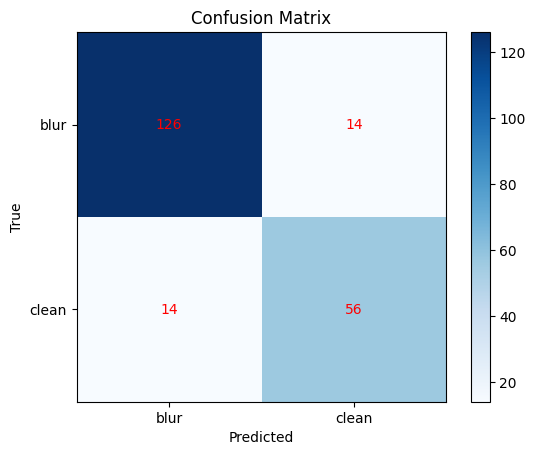

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(2), labels)
plt.yticks(range(2), labels)
plt.xlabel("Predicted"); plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')

plt.show()


In [28]:
from tensorflow.keras.models import load_model
classifier = load_model("/kaggle/working/blur_classifier.h5")

label_map = {v:k for k,v in train_gen.class_indices.items()}

def predict_blur(img):
    img = cv2.resize(img, (224,224)).astype('float32')/255.
    pred = classifier.predict(np.expand_dims(img,0))[0]
    label = label_map[np.argmax(pred)]
    return label, pred


In [21]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [29]:
# Part 1: The Vision Module (Novelty 1: Pre-processing)
import cv2
import numpy as np

def preprocess_and_correct_image(image):
    """
    This function finds a document in an image, corrects its perspective,
    and enhances its quality for better OCR results.
    """
    print("[INFO] Part 1: Pre-processing and correcting image perspective...")
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    orig_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use Gaussian blur and Canny edge detection to find document edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)

    # Find the largest contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Find the 4-point contour of the document
    screen_cnt = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screen_cnt = approx
            break

    # If a 4-point contour is found, apply perspective transform
    if screen_cnt is not None:
        print("[INFO] Document contour detected. Applying perspective correction.")
        pts = screen_cnt.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        (tl, tr, br, bl) = rect

        width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        max_width = max(int(width_a), int(width_b))

        height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        max_height = max(int(height_a), int(height_b))

        dst = np.array([[0, 0], [max_width-1, 0], [max_width-1, max_height-1], [0, max_height-1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(orig_image, M, (max_width, max_height))
    else:
        # Fallback if no contour is found
        print("[WARN] No document contour found. Using original image.")
        warped = orig_image

    # Final contrast enhancement on the corrected image
    final_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_image = clahe.apply(final_gray)

    return orig_image, final_image

In [30]:
# Part 2: The Text Assembly Module (Novelty 2: Post-processing)

def assemble_text_from_results(ocr_results):
    """
    Sorts OCR results based on vertical position and joins them
    into a single coherent block of text.
    """
    print("\n[INFO] Part 2: Assembling text into correct reading order...")
    # Sort the text blocks by their vertical position (y-coordinate of the top-left corner)
    sorted_results = sorted(ocr_results, key=lambda r: r[0][0][1])

    # Join the sorted text blocks into a single string
    full_text = " ".join([text for bbox, text, prob in sorted_results])

    return full_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[INFO] Document quality predicted as: clean
[ACTION] Proceeding without sharpening.
[ACTION] Preprocessing
[INFO] Part 1: Pre-processing and correcting image perspective...
[INFO] Document contour detected. Applying perspective correction.

[INFO] Running EasyOCR on the processed image...

[INFO] Part 2: Assembling text into correct reading order...

      INTELLIGENT DOCUMENT READER RESULTS

--- RAW DETECTED FRAGMENTS (FOR DEBUGGING) ---

Text: 'Mid-Semester Examination', Confidence: 0.9930
Text: 'PHI 453: Philosophy of Religion', Confidence: 0.7889
Text: 'Time allotted: 90 Minutes', Confidence: 0.7269
Text: 'Date: 18th   September  2025', Confidence: 0.6569
Text: 'Marks: 25', Confidence: 0.9782
Text: 'This question paper has three questions: Answer any', Confidence: 0.6442
Text: 'one', Confidence: 0.9948
Text: 'question for 25 marks', Confidence: 0.7351
Text: 'Your answer will be in the form of an essay with clearly labelled parts (if required by',

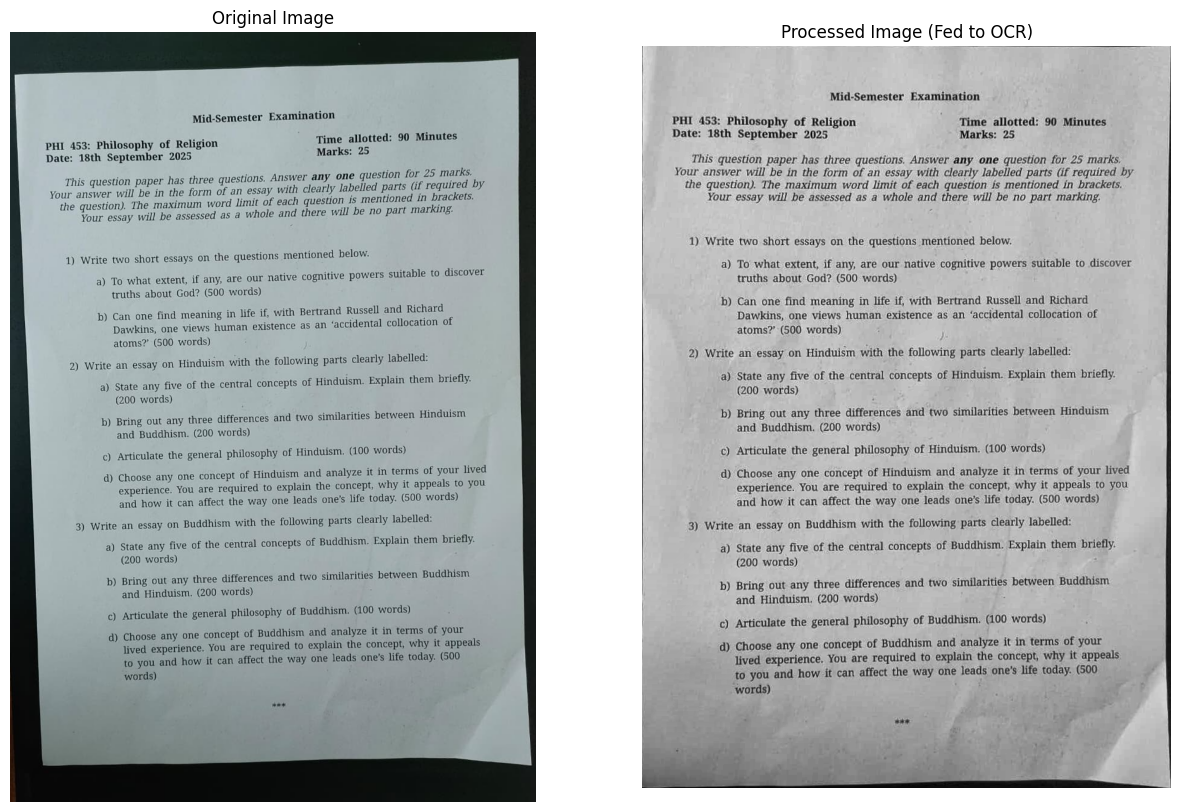

In [31]:
# Part 3: Main Execution Block

import easyocr
import matplotlib.pyplot as plt

# --- Configuration ---
IMAGE_PATH = '/kaggle/input/test-doc/test_doc.jpg'
image = cv2.imread(IMAGE_PATH)
label, prob = predict_blur(image)

print(f"[INFO] Document quality predicted as: {label}")

if label == "clean":
    print("[ACTION] Proceeding without sharpening.")
else:
    print("[ACTION] Applying sharpening filter...")
    image = cv2.filter2D(image, -1, np.array([[0, -1, 0],
                                              [-1, 5, -1],
                                              [0, -1, 0]]))
# --- Step 1: Pre-process the image ---
print("[ACTION] Preprocessing")
original_image, processed_image = preprocess_and_correct_image(image)

# --- Step 2: Run the OCR Engine on the CLEAN image ---
print("\n[INFO] Running EasyOCR on the processed image...")
reader = easyocr.Reader(['en'], gpu=False)
# Use paragraph=False to get individual text blocks, which gives us more control
results = reader.readtext(processed_image, paragraph=False)

# --- Step 3: Assemble the text (Novelty 2) ---
full_extracted_text = assemble_text_from_results(results)

# --- Step 4: Display the results for comparison ---
print("\n" + "="*50)
print("      INTELLIGENT DOCUMENT READER RESULTS")
print("="*50)

print("\n--- RAW DETECTED FRAGMENTS (FOR DEBUGGING) ---\n")
for (bbox, text, prob) in results:
    print(f"Text: '{text}', Confidence: {prob:.4f}")

print("\n" + "="*50)
print("\n--- FINAL ASSEMBLED TEXT ---\n")
print(full_extracted_text)
print("\n" + "="*50)

# Display the original vs. processed image to see the improvement
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(processed_image, cmap='gray')
axes[1].set_title('Processed Image (Fed to OCR)')
axes[1].axis('off')

plt.show()